In [67]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

import cv2
from PIL import Image
import matplotlib.pyplot as plt


In [66]:
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def show_random_examples(
    df,
    k=10,
    kind=None,      # "wt", "mu", or None
    seed=None,
):
    if seed is not None:
        random.seed(seed)

    df_work = df.copy()

    # --- optional filtering ---
    if kind == "wt":
        df_work = df_work[
            df_work["old_file_name"].astype(str).str.startswith("wtimage")
        ]
    elif kind == "mu":
        df_work = df_work[
            df_work["old_file_name"].astype(str).str.startswith("muimage")
        ]

    if df_work.empty:
        raise ValueError("No images match the filter.")

    k = min(k, len(df_work))
    indices = random.sample(range(len(df_work)), k)

    for id_num in indices:
        new_id = df_work["new_id_padded"].iloc[id_num]
        old_file_name = df_work["old_file_name"].iloc[id_num]

        if pd.isna(old_file_name):
            continue

        # --- raw image ---
        im0 = np.array(
            Image.open(
                f"/home/ascott10/documents/projects/pub_viruses/renamed_images/{new_id}.png"
            ).convert("RGB")
        )

        # --- manual segmentation ---
        if old_file_name.startswith("muimage"):
            seg_dir = "mutant_manual_correction"
        elif old_file_name.startswith("wtimage"):
            seg_dir = "wildtype_manual_correction"
        else:
            continue

        im1 = np.array(
            Image.open(
                f"/home/ascott10/documents/projects/pub_viruses/segmented_images/{seg_dir}/{old_file_name}"
            ).convert("RGB")
        )

        # --- SAM mask ---
        im2 = np.array(
            Image.open(
                f"/home/ascott10/documents/projects/pub_viruses/sam_masks/mask_{new_id}.png"
            ).convert("RGB")
        )

        # --- plot ---
        fig, ax = plt.subplots(1, 3, figsize=(10, 30))

        ax[0].imshow(im0)
        ax[0].set_title(f"Raw image\n{new_id}.png")
        ax[0].axis("off")

        ax[1].imshow(im1)
        ax[1].set_title(f"Manual Segmentation\n{old_file_name}")
        ax[1].axis("off")

        ax[2].imshow(im2)
        ax[2].set_title(f"SAM 2 Segmentation\nmask_{new_id}.png")
        ax[2].axis("off")

        plt.show()

In [58]:
df = pd.read_csv("references/do_not_view_renamed_images.txt", delim_whitespace=" ")



df["new_id_padded"] = (
    df["new_id"]
    .apply(lambda x: f"{int(x):03d}" if pd.notna(x) else x)
)

df["old_file_name"] = df["seg_name"].str.extract(
    r"((?:muimage\d+(?:_corrected)?\.png)|(?:wtimage\d+(?:_corrected)?\.tif)|(?:wtimage\d+(?:_corrected)?\.png))"
)



df["old_file_name"].unique()

/tmp/ipykernel_1659/1493648277.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("references/do_not_view_renamed_images.txt", delim_whitespace=" ")


array(['muimage1_corrected.png', 'muimage2_corrected.png', nan,
       'muimage4_corrected.png', 'muimage6_corrected.png',
       'muimage7_corrected.png', 'muimage8_corrected.png',
       'muimage9_corrected.png', 'muimage10_corrected.png',
       'muimage11_corrected.png', 'muimage12_corrected.png',
       'muimage13_corrected.png', 'muimage14_corrected.png',
       'muimage15_corrected.png', 'muimage16_corrected.png',
       'muimage17_corrected.png', 'muimage18_corrected.png',
       'muimage19_corrected.png', 'muimage20_corrected.png',
       'muimage21_corrected.png', 'muimage22_corrected.png',
       'muimage23_corrected.png', 'muimage24_corrected.png',
       'muimage25_corrected.png', 'muimage27_corrected.png',
       'muimage29_corrected.png', 'muimage31_corrected.png',
       'muimage32_corrected.png', 'muimage33_corrected.png',
       'muimage34_corrected.png', 'muimage37_corrected.png',
       'muimage38_corrected.png', 'muimage39_corrected.png',
       'muimage40_correcte

In [59]:
dir_name = Path("sam_masks")
files = sorted(p.name for p in dir_name.iterdir())

ids = sorted(p.stem.split("_")[-1]
             for p in dir_name.glob("*.png"))

ids

df_filtered = df[df["new_id_padded"].isin(ids)].sort_values(by = "new_id")
df_filtered[["new_id_padded", "old_file_name"]]

,new_id_padded,old_file_name
623,001,NaN
341,002,muimage342_corrected.png
416,003,muimage417_corrected.png
756,004,NaN
138,005,muimage139_corrected.png
...,...,...
422,886,muimage423_corrected.png
792,888,NaN
376,893,muimage377_corrected.png
35,901,NaN


In [60]:
new_id = str(df_filtered["new_id_padded"].iloc[2])
old_file_name = df.loc[df["new_id_padded"] == new_id, "old_file_name"].iloc[0]

if "muimage" in old_file_name:
    im1 = Image.open(f'/home/ascott10/documents/projects/pub_viruses/segmented_images/mutant_manual_correction/{old_file_name}')
elif "wtimage" in old_file_name:
    im1 = Image.open(f'/home/ascott10/documents/projects/pub_viruses/segmented_images/wildtype_manual_correction/{old_file_name}')

In [73]:
new_df = df_filtered[["type", "new_id_padded"]].copy()
base_dir = "/home/ascott10/documents/projects/pub_viruses/sam_masks"

new_df["new_id_padded"] = "mask_" + new_df["new_id_padded"]
new_df["file_path"] = base_dir  + "/mask_" + new_df["new_id_padded"] + ".png"
new_df.rename(columns = {"new_id_padded": "im_id", 
                       "type": "class"}, inplace=True)

new_df.to_csv("/home/ascott10/documents/projects/pub_viruses/references/sam_2_segmented_images.csv")

len(new_df)

216

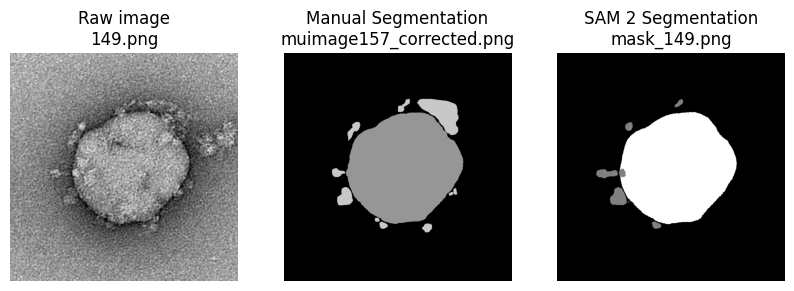

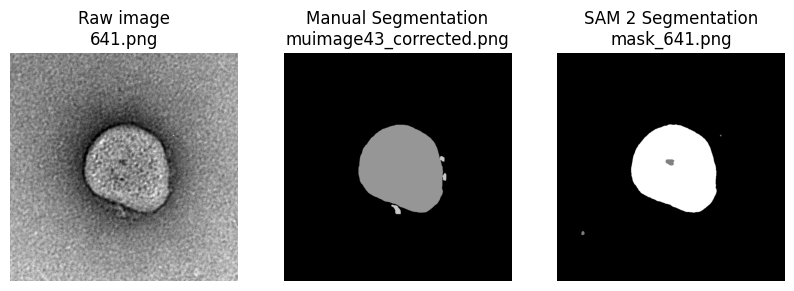

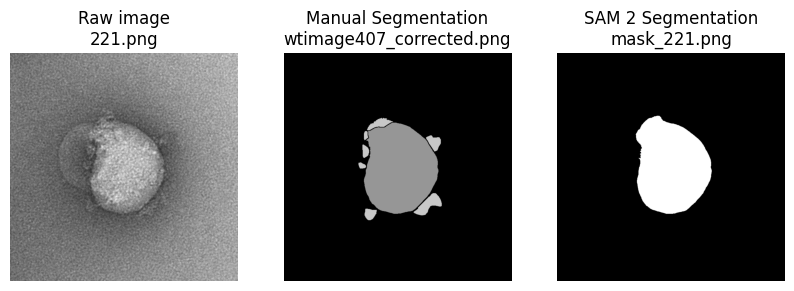

In [75]:
dir_name = Path("sam_masks")
ids = sorted(p.stem.split("_")[-1] for p in dir_name.glob("*.png"))

df_filtered = df[df["new_id_padded"].isin(ids)].sort_values(by = "new_id")
#df_filtered[["new_id_padded", "old_file_name"]]

show_random_examples(df_filtered, k=5)
#show_random_examples(df_filtered, k=5, kind="wt")
#show_random_examples(df_filtered, k=5, kind="mu")
#show_random_examples(df_filtered, k=5, kind="wt", seed=42)

new_df = df_filtered[["type", "new_id_padded"]].copy()
base_dir = "/home/ascott10/documents/projects/pub_viruses/sam_masks"
new_df["new_id_padded"] =  "mask_" + new_df["new_id_padded"]
new_df["file_path"] = base_dir  + "/" + new_df["new_id_padded"] + ".png"

new_df.rename(columns = {"new_id_padded": "im_id", 
                       "type": "class"}, inplace=True)
new_df.to_csv("/home/ascott10/documents/projects/pub_viruses/references/sam_2_segmented_images.csv")
